# Importing Libraries

In [74]:
import pandas as pd
import numpy as np
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning

In [76]:
def safe_convert(col):
    col_cleaned = col.replace(',', '', regex=True)
    return pd.to_numeric(col_cleaned, errors='coerce')

setpt = pd.read_csv('setpoint_publish(in).csv')
setpt = setpt.apply(lambda col: safe_convert(col) if col.name != 'var' else col)
setpt

,var,opt_mean,opt_sig,drift_mean,drift_sig,excursion_mean,excursion_sig
0,x1,22.1,0.295,22.111,0.442,22.115,0.5900
1,x2,44.8,1.045,46.010,1.840,46.547,2.3270
2,x4,0.4,0.023,0.368,0.027,0.304,0.0670
3,x5,150000.0,8000.000,135000.000,9000.000,120000.000,16000.0000
4,x7,1206.0,48.240,1266.300,75.978,1266.300,88.6410
5,x8,87.0,5.220,91.176,6.686,107.880,12.2264
6,x9,454.0,19.673,456.270,22.814,599.280,69.9160
7,x17,5492.0,256.293,5526.050,349.983,5552.410,425.6850
8,x3,NaN,NaN,39.000,2.860,NaN,NaN
9,x6,NaN,NaN,112.000,6.720,NaN,NaN


# Generating the dataset

In [78]:
def generate_normal_data(mean, std_dev, size=5000, seed=None):
    return np.random.normal(loc=mean, scale=std_dev, size=size)

def generate_skewed_normal_data(mean, std_dev, skew, size=5000, seed=None):
    return skewnorm.rvs(skew, loc=mean, scale=std_dev, size=size)

In [79]:
datasets = {} # dict to store the generated number
skew_variables = {
    "x4": 200,
    "x5": 200,
    "x8": -100,
    "x9": -200
}

for data_name in ["opt", "drift", "excursion"]:
    rows = []
    for var, mean, sig in zip(setpt['var'], setpt[f'{data_name}_mean'], setpt[f'{data_name}_sig']):
        if data_name == "excursion" and var in skew_variables:
            # Generate skewed data for the specified variables (x4, x5, x8, x9)
            skew = skew_variables[var]
            rows.append(generate_skewed_normal_data(mean=mean, std_dev=sig, skew=skew, size=5000, seed=42))
        else:
            # Generate normal data for other variables
            rows.append(generate_normal_data(mean=mean, std_dev=sig, size=5000, seed=42))

    # Assign the generated data to the dataset
    datasets[data_name] = pd.DataFrame(np.column_stack(rows), columns=setpt['var'])

In [80]:
opt_data = datasets['opt']
drift_data = datasets['drift']
exc_data = datasets['excursion']

# drop unnecessary columns
#opt_data.drop(columns=[' x3 ', ' x6 ', ' x10 ', ' x11 ', ' x12 ', ' x13 ', ' x14 ', ' x15 ', ' x16 ', ' x18 ', ' x19 '], axis = 1, inplace=True)
#exc_data.drop(columns=[' x3 ', ' x6 ', ' x10 ', ' x11 ', ' x12 ', ' x13 ', ' x14 ', ' x15 ', ' x16 ', ' x18 ', ' x19 '], axis = 1, inplace=True)

# Outcome 

In [82]:
opt_data['outcome'] = (-( 5 * np.pi * 10**4 * opt_data['x1'] + 770 * (opt_data['x2'] ** 2) +
    58 * opt_data['x5'] * opt_data['x4'] - 890 * opt_data['x17'] + 730.5 * opt_data['x7'] ) / (8 * 10**5) + 7.5)


drift_data['outcome'] = (-( 5 * np.pi * 10**4 * drift_data['x1'] + 770 * (drift_data['x2'] ** 2) +
    58 * drift_data['x5'] * drift_data['x4'] - 890 * drift_data['x17'] + 730.5 * drift_data['x7'] ) / (8 * 10**5) 
    + (39 * drift_data['x5'] * drift_data['x9'] * drift_data['x8']) / (10**11) + 7)

exc_data['outcome'] = (-( 5 * np.pi * 10**4 * exc_data['x1'] + 770 * (exc_data['x2'] ** 2) +
    58 * exc_data['x5'] * exc_data['x4'] - 890 * exc_data['x17'] + 730.5 * exc_data['x7'] ) / (8 * 10**5) 
    + (39 * exc_data['x5'] * exc_data['x9'] * exc_data['x8']) / (10**11) + 7 
    + ((0.8 * exc_data['x4'] * (exc_data['x5'])**2 * exc_data['x17'] ) / (10**13)))


In [83]:
opt_data

var,x1,x2,x4,x5,x7,x8,x9,x17,x3,x6,x10,x11,x12,x13,x14,x15,x16,x18,x19,outcome
0,22.103581,45.733342,0.446646,166281.576067,1298.950967,86.366360,454.776569,5511.817664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.708161
1,22.659395,45.825933,0.418951,137826.804226,1230.130485,82.599861,446.344759,5358.917860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.681766
2,21.682364,43.642713,0.420918,155552.512057,1220.571785,83.796276,478.797618,5668.158607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.853782
3,21.896189,44.697931,0.377528,145174.212877,1116.272765,87.655533,439.361668,5234.311217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.108058
4,22.017076,44.440676,0.397857,136668.475449,1235.390419,88.763013,444.571522,5132.475721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.915710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,22.270968,43.843176,0.383904,148494.504938,1244.577326,83.120254,438.089259,5724.267835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.375706
4996,22.210767,45.531326,0.417725,140925.007782,1268.279612,79.931630,437.254951,5872.562341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.250767
4997,21.900226,42.236435,0.396704,145632.356610,1188.821529,85.663594,439.032822,5318.078020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.125161
4998,21.922420,45.086448,0.405773,158104.747190,1179.880603,88.443394,460.537110,5614.898076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.756965


In [84]:
drift_data

var,x1,x2,x4,x5,x7,x8,x9,x17,x3,x6,x10,x11,x12,x13,x14,x15,x16,x18,x19,outcome
0,22.821030,43.847010,0.326864,133732.931675,1416.908522,85.117206,482.635013,5924.194525,37.834281,112.104117,544.879000,8.002628,13996.648577,352.874360,9450.841264,25.188160,656.476304,119636.621298,6704.308276,4.938926
1,22.142938,42.868663,0.346662,131028.085676,1305.802080,93.692216,469.770736,6255.481039,43.264551,114.679285,545.710462,7.878412,15753.860886,320.513380,8457.417863,28.860621,653.186681,114757.370782,6630.592784,5.606325
2,22.310133,45.975297,0.358252,127958.037598,1340.685155,100.052412,463.946580,5875.180073,38.739490,113.729962,540.939479,8.157443,15480.454617,346.826786,9398.607406,27.532015,655.917078,125681.598985,6410.093968,4.889864
3,21.903177,47.972195,0.400488,133120.505141,1270.021845,81.346648,438.405417,5183.206797,39.413026,110.897429,572.384816,8.192546,14886.360167,353.073099,8995.529553,27.312126,633.683591,124992.579055,6765.536472,3.077225
4,21.915890,45.184690,0.369795,129241.235903,1316.084327,98.273141,444.625281,5435.090505,39.182993,120.845105,565.730798,8.045491,14608.223529,327.509348,8141.601753,29.014088,630.064995,116550.706292,6882.182612,4.313940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,21.797023,46.855266,0.319315,129769.955590,1172.749557,78.239512,489.921661,5591.390327,40.991857,107.695909,585.887193,7.758193,13736.795009,329.766599,8413.736804,29.475821,622.675458,121205.582862,7013.696297,4.692370
4996,21.383517,45.688323,0.422534,136517.725717,1213.597341,96.895392,442.723827,6260.539759,38.661939,116.366055,545.634717,8.053349,16986.963779,342.561077,7593.152707,27.689004,648.843062,135251.070322,6178.014356,4.750814
4997,22.313613,45.125940,0.385753,136763.164923,1197.811350,85.261777,514.407803,5458.938353,41.993927,102.135696,552.326847,7.885330,15208.679155,350.029786,8242.374546,27.276848,635.232564,124498.004941,6929.843270,4.152543
4998,22.246659,42.801778,0.356287,139884.786703,1276.592431,82.456579,440.780473,4651.689796,35.550374,121.420377,582.551076,8.365435,13724.413035,336.760451,8619.193816,26.774934,616.375198,128381.827252,6987.160854,3.247378


In [85]:
exc_data

var,x1,x2,x4,x5,x7,x8,x9,x17,x3,x6,x10,x11,x12,x13,x14,x15,x16,x18,x19,outcome
0,22.186974,47.123779,0.305077,122636.959014,1196.845831,106.685468,574.713348,5853.820162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.294491
1,22.195822,47.208142,0.368040,152164.814889,1269.520536,92.125495,576.470335,5514.592096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.323484
2,22.489205,47.197387,0.400897,128744.332597,1276.098255,102.255276,590.781955,5695.833776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.930712
3,21.863695,45.647604,0.363978,135892.357087,1144.255451,95.810904,465.536523,5362.942274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.284601
4,21.815262,49.557959,0.306323,126476.981355,1231.087949,93.252639,544.248220,5271.263240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.853771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,22.589406,44.168738,0.485807,124748.792372,1210.015463,107.392445,538.744004,5588.035628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.599498
4996,22.186907,40.990882,0.347450,131860.900700,1368.832754,101.222440,524.204942,5141.991296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.389154
4997,22.913334,44.633372,0.311959,131986.764180,1345.338844,97.042203,558.311002,6110.892775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.613958
4998,22.635699,45.690545,0.325394,124177.682022,1383.684893,107.334756,593.445290,5363.299066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.557550


In [86]:
opt_data.to_csv("data/opt_data.csv", index=None)
drift_data.to_csv("data/drift_data.csv", index=None)
exc_data.to_csv("data/excursion_data.csv", index=None)

# Plotting

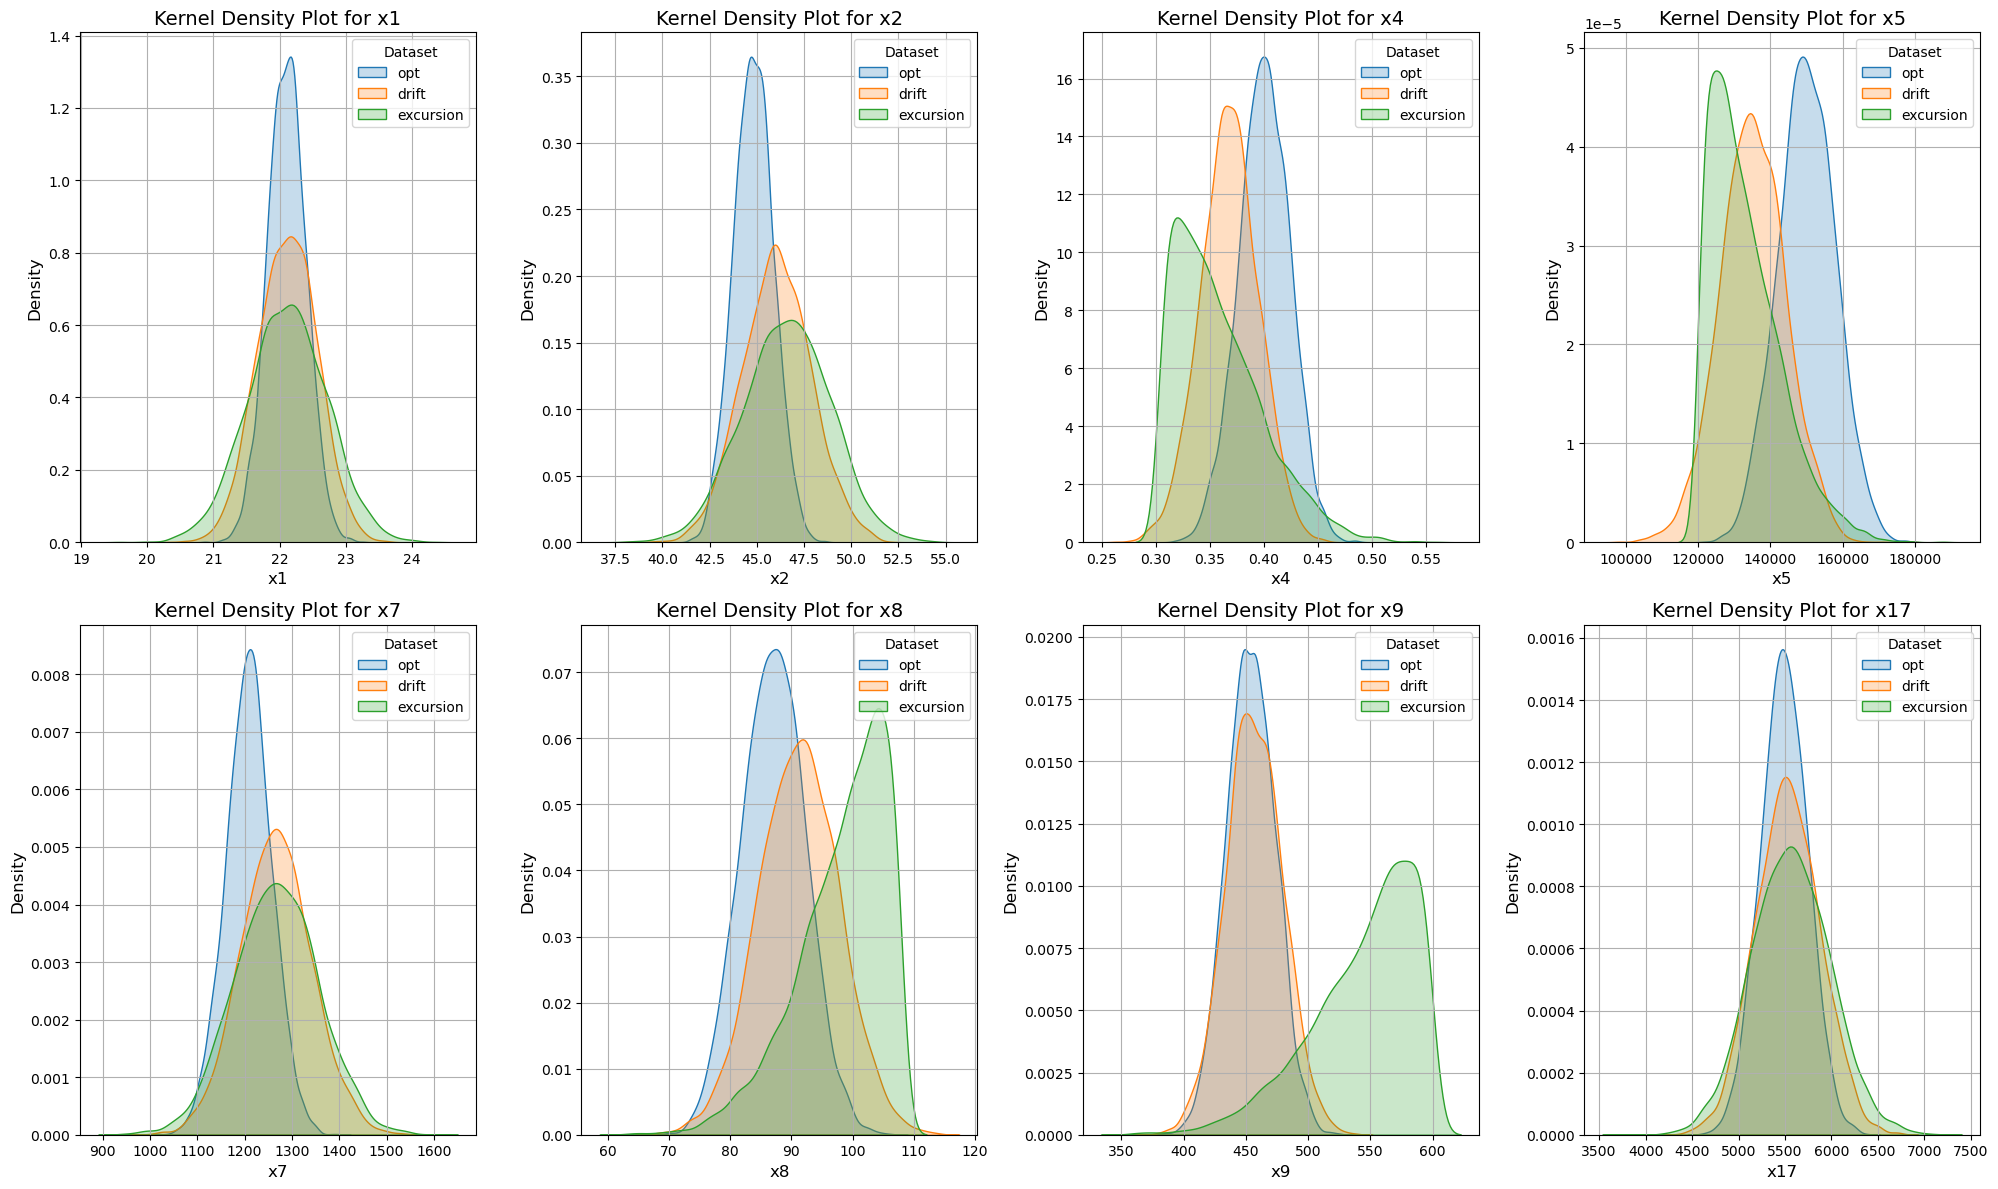

In [88]:
selected_variables = ['x1', 'x2', 'x4', 'x5', 'x7', 'x8', 'x9', 'x17']

plots_per_row = 4
num_variables = len(selected_variables)
num_rows = (num_variables + plots_per_row - 1) // plots_per_row 

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, 6 * num_rows))
axes = axes.flatten()  

# Generate the plots for the selected variables
for i, variable in enumerate(selected_variables):
    ax = axes[i]
    for name, df in datasets.items():
        sns.kdeplot(df[variable], label=name, fill=True, ax=ax)
    ax.set_title(f'Kernel Density Plot for {variable}', fontsize=14)
    ax.set_xlabel(variable, fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.legend(title='Dataset')
    ax.grid(True)

# Remove excess subplots if needed
for j in range(len(selected_variables), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

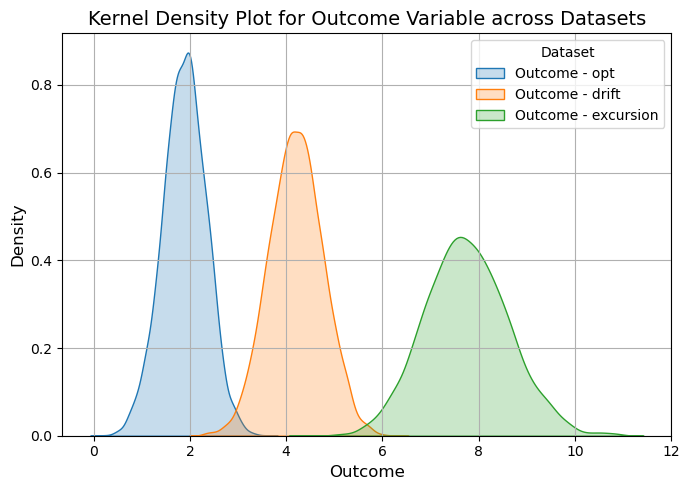

In [89]:
plt.figure(figsize=(7, 5))

# Loop over the datasets and plot the KDE for the 'outcome' variable in each
for name, df in datasets.items():
    sns.kdeplot(df['outcome'], label=f'Outcome - {name}', fill=True)

# Add labels and title
plt.title('Kernel Density Plot for Outcome Variable across Datasets', fontsize=14)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Dataset')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

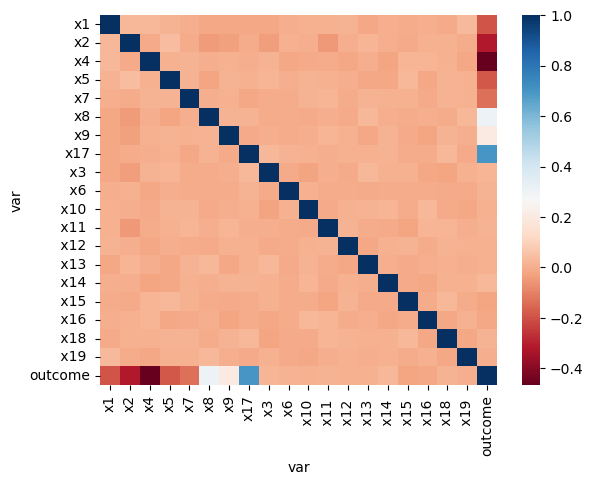

In [90]:
corr = drift_data.corr()

sns.heatmap(corr, 
            cmap='RdBu', 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

C:\Users\hrith\AppData\Local\Temp\ipykernel_27216\2079452644.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  interaction_table_binned = drift_data_cleaned.pivot_table(


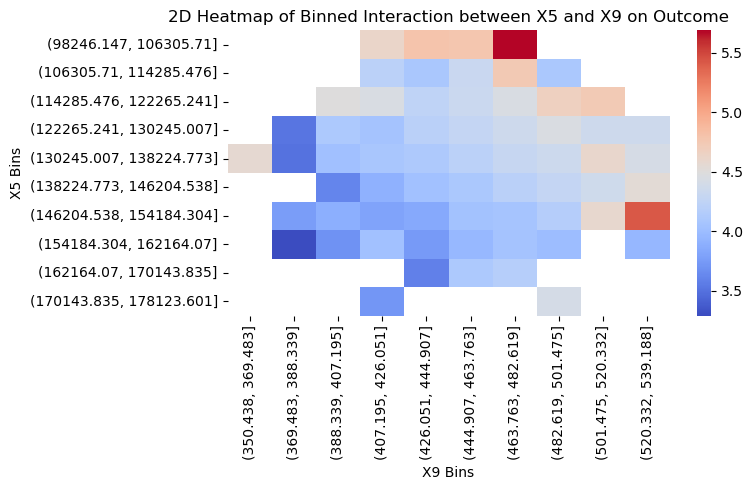

In [91]:
drift_data_cleaned = drift_data.dropna(subset=['x5', 'x9', 'outcome'])

drift_data_cleaned['x5_bins'] = pd.cut(drift_data_cleaned['x5'], bins=10)
drift_data_cleaned['x9_bins'] = pd.cut(drift_data_cleaned['x9'], bins=10)

# Create a pivot table with the binned values
interaction_table_binned = drift_data_cleaned.pivot_table(
    values='outcome', 
    index='x5_bins', 
    columns='x9_bins', 
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(interaction_table_binned, cmap="coolwarm", annot=False)
plt.title("2D Heatmap of Binned Interaction between X5 and X9 on Outcome")
plt.xlabel("X9 Bins")
plt.ylabel("X5 Bins")
plt.tight_layout()
plt.show()